# Makemore

This notebook implements "makemore" from Karpathy's lecture series, an autoregressive bigram character-level language model. We focus on 1) using torch to build and evaluate neural networks, and 2) the framework of language modeling including model training, sampling, and evaluation of the negative log likelihood loss.

- Character level model: Means that the model treats each instance at a character level. E.g., "Gerrit" is treated as a sequence of characters: "Ge"- "er"- "rr"-"it".

- Language model: Learns the distribution from the character sequences and then predicts the next most likely sequence based on an input sequence.


In [239]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
%matplotlib inline

## Data

The data we use is a list of about 30k names, with which we will train a language model. From the training corpus the model creates new names.

In [196]:
# Load data, read data, and split by lines which creates a list of names
words = open("/Users/gerritquaremba/Library/CloudStorage/GoogleDrive-g.quaremba@gmail.com/My Drive/08_NN_Kaparthy/makemore/names.txt", 'r').read().splitlines()

In [197]:
# Look at the word file
print(words[:10])

# n words
print('n words ', len(words))

# Shortest name
print("Shortest name" , min(len(word) for word in words))

# Longest name
print("Longest name" , max(len(word) for word in words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
n words  32033
Shortest name 2
Longest name 15


## Language Model

A given word in the corpus contains a lot of information. The word "Isabella", for example, contains information about each character. In this case, "I" is likely to come first, followed by "s". "a" is likely to follow after "Is", and so on, all the way to the final "a". The last "a" also gives us information, namely, that the word ends with it. Therefore, each character of a word contains a unique bit of information about the word's statistical structure. A language model learns this information.

We will now implement a _bigram_ language model, that is, we are only focusing on two characters at a time. We thus only look at the previous character to predict the next one. We lose a lot of information with such a short dependency, but it can be extended to larger ones.


__Bigrams__ Next, we build bigrams. The simplest way to learn information from bigrams is to count their occurrences in the training set.

- Special tokens: We add special start and end tokens to each word to capture the information about both. Typically, these tokens are denoted as `<S>` for start or `<E>` for end, but we will use a "." as a single special character. This approach helps avoid instances where the start token is mistakenly placed at the end, and vice versa for the end token.


In [198]:
# Dict containing counts of bigrams
b={} # key: bigrams; value: counts

# Build bigrams
for w in words[:]:
    w = ['.'] + list(w) + ['.'] # Special token to indicate beginning and end
    for ch1, ch2 in zip(w, w[1:]): # exploit zip to get bigrams
        bigram=(ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1 # get() in case bigram is not yet part of the dict

In [174]:
# Dict
sorted(b.items(), key=lambda kv: -kv[1]) # sort descending order

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

From the individual counts of bigrams, we can see that the most likely bigram is "n.", this is, that a name ends with "n".

__Tensor__

A more convenient and efficient way to store this information is in a 2-dimensional array, where rows represent the first character, and columns represent the second character. The entry in this array will keep the count of how often the second character follows the first in the training data. We can use a tensor to construct this array.


In [199]:
# A simple example, this is a 2-D array of zeros
zeros = torch.zeros([3, 5], dtype=torch.int32)

# We can change a single value via indexing
zeros[1, 3] = 1

zeros

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

For the names data, we have 26 letters of the alphabet, plus one special character. Therefore, we need a 27x27 array. To map characters to the array, we require a lookup table that maps characters to integer indices of the array.


In [200]:
# For the names data the 2-D array is initialised
N = torch.zeros((27, 27), dtype=torch.int32)
N

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],


In [201]:
# Lookup table: assign each char a unique integer

# 1. Get unique chars
chars = sorted(list(set(''.join(words))))

# 2. Map chars to int (string to int=stoi)
stoi = {s:i+1 for i, s in enumerate(chars)} # enum indexes a list; +1 as we add special token at one later

# Add special char
stoi['.'] = 0
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

We can use this lookout table to fill the tensor.

In [202]:
# Fill the tensor
for w in words[:]:
    chs = ['.'] + list(w) + ['.'] # Special token to indicate beginning and end
    for ch1, ch2 in zip(chs, chs[1:]): # exploit zip to get bigrams
        ix1, ix2 = stoi[ch1], stoi[ch2] # get indexes
        N[ix1, ix2] +=1 # count the cell of the tensor

We can visualise this tensor below, cpoying the code from Karpathy's video. Again, each cell indicates the count of how often the second character followes the first one. For exmaple, "a" follows "a" 556 times.

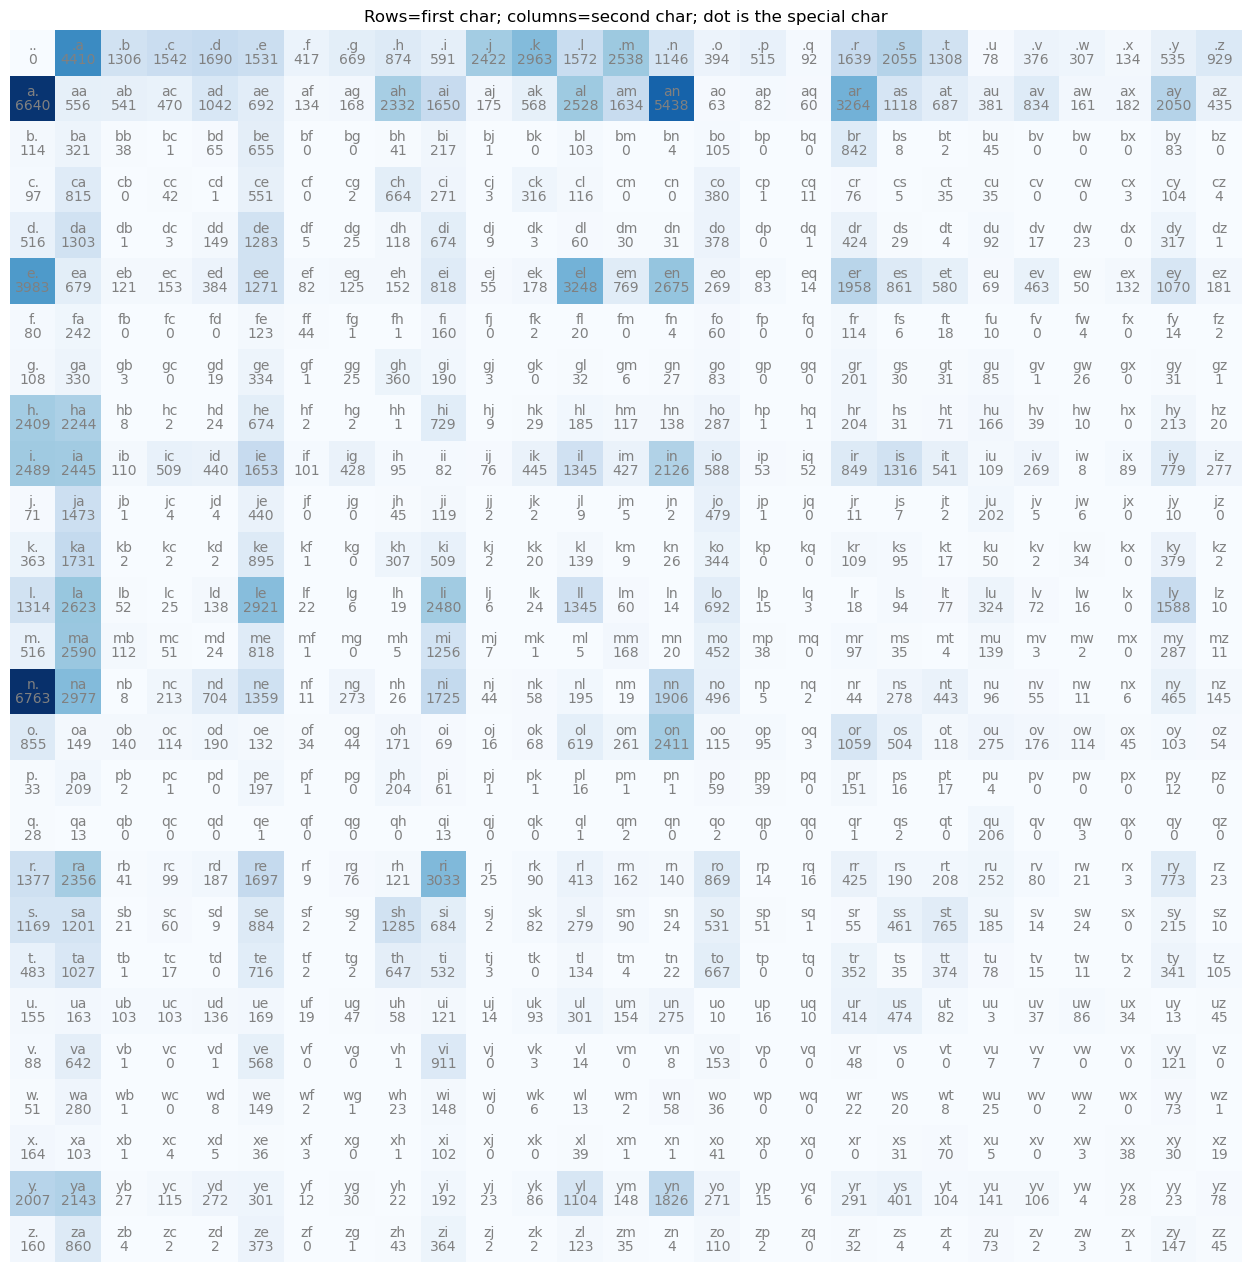

In [203]:
# Code from the video

# integer to string mappgin, reverse of stoi
itos = {i:s for s, i in stoi.items()}

# Vis
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.title('Rows=first char; columns=second char; dot is the special char');

### Sampling

The array mentioned above contains all the information we need to sample from the character-level language model. The idea is to follow the probabilities derived from the training data and sample based on them. We will begin with the start token and continue sampling until we reach the end token. The sequence of characters thus formed is the sampled word.

The start of this process is represented by the first row, as the first character must be the special character with which a word begins.


In [84]:
# Accessing the first row
p = N[0].float()

This produces a 1-dimensional array containing the counts of all possible character beginnings. What we aim to do is to sample from this row, and for this purpose, we need the probabilities of each character. Dividing each count in this array by the sum of all counts yields the probability distribution of the first character. Consequently, each entry then provides the probability of a given character starting a word.


In [204]:
# Normalise counts to get probabilities
p = p / p.sum()

__Sampling with Torch__

The multinomial distribution is a generalization of the binomial distribution that assumes multiple possible outcomes, each with a fixed probability of occurring.

Torch's multinomial distribution function outputs integers according to the probabilities we input. We will use this to sample the characters using the probabilities we have just computed.

We will employ a generator object which randomly draws from a pre-specified distribution. As an example:


In [205]:
# Create generator (with seed for replicability)
g = torch.Generator().manual_seed(2147483647)

# Create random numbers, using the generator
p = torch.rand(3, generator=g)
p = p / p .sum()
print(p)

# Now randomly draw the index of the p array with replacement
torch.multinomial(p, num_samples=10, replacement=True, generator=g)


tensor([0.6064, 0.3033, 0.0903])


tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0])

Here, `p` is an array of probabilities from which we randomly draw outcomes (indexes) using `multinomial`. We expect that with more samples drawn, we will approach the distribution given by `p`. For example, if the probability of the first outcome in `p` is about 60%, then we would expect roughly the same percentage of outcomes in our random draw.

We can apply this principle to the first row of the 2-D array of counts.


In [206]:
# Initialise generator
g = torch.Generator().manual_seed(2147483647)

# Draw random counts
p = N[0].float()

# Normalise
p = p / p.sum()

# Now draw random beginning from the probs
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

# Which is the beginning
itos[ix]

'j'

### Training

As we will consistently utilize probabilities for training, we can convert the matrix of counts, `N`, into a matrix of probabilities, `P`, by dividing each row by its sum. Consequently, each row is normalized, ensuring that the sum of each row is 1.


In [207]:
# Get floating point N
P = N.float()

__Extra: Broadcasting__

We need to be careful when we sum a tensor.

In [208]:
# Returns a single scalar; takes the sum of the entire matrix
print(P.sum().shape)

# Returns a 1-D array of size 27; takes the sum across columns
print(P.sum(dim=0).shape)

# Returns a 2-D array of size 1x27; takes the sum across columns
#  and keeps dim
print(P.sum(dim=0, keepdim=True).shape)

# Returns a 2-D array of size 27x1; takes the sum across rows
#  and keeps dim
print(P.sum(dim=1, keepdim=True).shape)

torch.Size([])
torch.Size([27])
torch.Size([1, 27])
torch.Size([27, 1])


So, what we need is a `27x1` column vector to normalize each row.

However, we need to consider broadcasting rules. Broadcasting refers to the rules followed when combining two arrays of different shapes. In PyTorch, two tensors are broadcastable if:

1. Each tensor has at least one dimension.
2. Starting at the trailing dimension, the size of each dimension must be either equal, one of them is 1, or one of them does not exist.

In our example, we are combining `P x P.sum()`, which have dimensions `27x27` and `27x1`, respectively. Each tensor has at least one dimension. Comparing each dimension with each other, we have size one for the second dimension of the sum tensor, and both dimensions are equal for the first dimension of `P`. Hence, both arrays are broadcastable. The essence of this operation is that the second column sum tensor (the `27x1` vector) is replicated 27 times (horizontally, not vertically) to match the first matrix (the `27x27` matrix). Then, this sum _matrix_ is applied to the `P` matrix in parallel, which increases efficiency.


In [209]:
# Normalise the column
P /= P.sum(1, keepdim=True)

In [210]:
# Check whether the sum of the first row is 1
P[0].sum()

tensor(1.)

What would have happened if we hadn't used the `keepdim=True` argument?

The first tensor is of size `27x27`, and without `keepdim=True`, the second tensor becomes size `27` (not `27x1` as `keepdim=True` would have preserved the dimensions).

Now, broadcasting does the following:

- P:     27x27
- P.sum: 27, which will be treated as `1x27` because broadcasting starts at the _trailing_ dimension. PyTorch inserts a 1 for the now first missing dimension, effectively turning this tensor into a _row_ vector. This is because broadcasting starts at the trailing dimension (you shift the dimensions to the right when given a tensor with fewer dimensions).

Broadcasting now repeats the second tensor vertically, meaning the final operation `P x P.sum()` divides each row by the _column_ sum, not the row sum.

We can visualise the `P` matrix, where the change is that we now have probabilites and not counts:

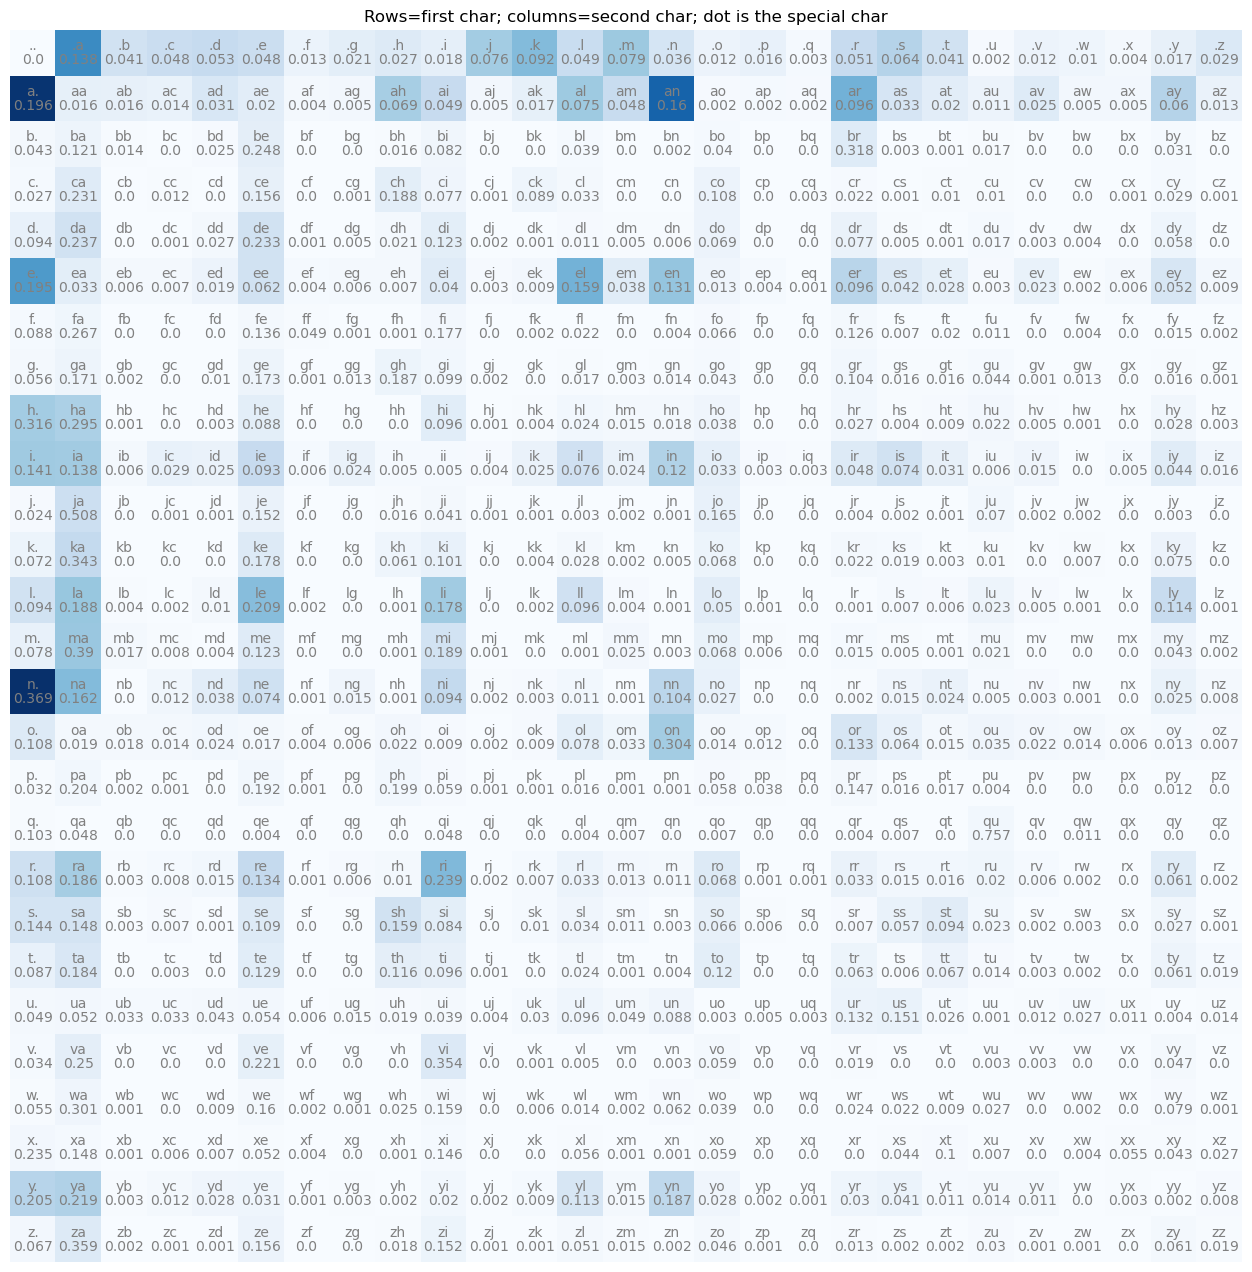

In [211]:
# Vis
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(P[i, j].item(), 3), ha="center", va="top", color='gray')
plt.axis('off')
plt.title('Rows=first char; columns=second char; dot is the special char');

We have successfully sampled the first character, "j". We can continue sampling by examining the row corresponding to the character "j" in the array. This row provides all the counts where "j" is the first character, followed by one of the other 27 characters.

We can construct a loop that continues to sample characters as long as the end token hasn't been sampled.


In [212]:
# Training the model
g = torch.Generator().manual_seed(2147483647)

# Creating 10 names
for _ in range(10):
    ix=0
    out=[]
    while True:

        # Draw random counts
        p=P[ix]

        # Now draw random column, which is the second char
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])


        # Break as soon as the end token is selected
        if ix==0:
            print(''.join(out))
            break



junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


If we run this a few times, we observe that the generated names are not very realistic. Why is this? It's because the language model only knows __one__ character for its prediction of the next one. For instance, when it outputs "a.", it only knows that it is somewhat likely that "a" is also the last character, so it returns ".". However, it does not know that "a" is also the first character. This is because the bigram model only considers one preceding token, which highlights its apparent limitation.

One way to see that the model actually performs not too badly is to compare it against an untrained model that assumes a uniform distribution for every character. The model below does exactly that:


In [213]:
# Model with uniform distribution
g = torch.Generator().manual_seed(2147483647)


for _ in range(10):
    ix=0
    out=[]
    while True:

        # Draw random counts
        # p = N[ix].float()
        # p = p / p.sum()

        # Assums uniform probs
        p = torch.ones(27)/27

        # Now draw random column, which is the second char
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])


        # Break as soon as the end token is selected
        if ix==0:
            print(''.join(out))
            break



juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.
rkrrsru.
iyumuyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.


We can observe that the model, which assumes equal probability for each character, outputs literally nonsense, indicating that the bigram model, despite its limitations, is somewhat closer to generating actual names.


#### Intermediate Summary

This demonstrates the training of a bigram language model (LM), where the training process simply involves counting how frequently certain bigrams appear in the training data. These counts were then normalized to form a probability distribution. Therefore, the model parameters are essentially the probabilities of these bigrams.



## Model Performance

Now, we aim to summarize the model's performance into a single number, known as the _loss_. This metric will inform us about the model's effectiveness.

To assess performance, we use the concept of likelihood, which is the product of all bigram probabilities for a given word. This product represents the likelihood of the word in the training distribution. The goal is to achieve as high a product as possible. However, since multiplying multiple low probabilities typically results in a very small number, the log-likelihood is commonly used for convenience.

But what is the intuition behind the log-likelihood?


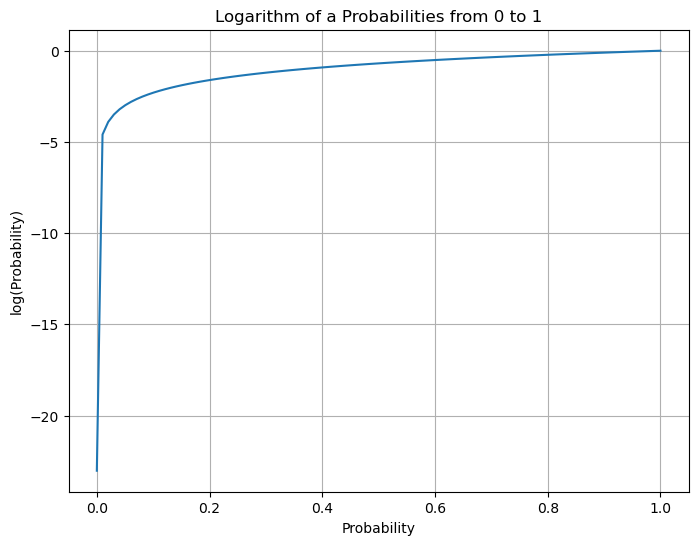

In [185]:
# Gen x and y values
x = np.linspace(0, 1, 100)
y = np.log(x + 1e-10)

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Logarithm of a Probabilities from 0 to 1')
plt.xlabel('Probability')
plt.ylabel('log(Probability)')
plt.grid(True)
plt.show()

The intuition is that characters with a probability close to 1 are assigned a value close to 0. Conversely, characters with a probability close to 0 are assigned a value approaching negative infinity. To compute the log-likelihood, we take the sum of the log probabilities of each character. To summarize:

- Likelihood: $\text{likelihood}(a, b, c) = a \times b \times c$

- Log probability: $\text{logprob}(a, b, c) = \log(a \times b \times c) = \log(a) + \log(b) + \log(c)$

Therefore, the closer the loss function is to zero, the better the model's performance. In other words, when all probabilities are 1, then the log-likelihood is 0, which is the highest it can be.

However, for the loss function, we typically prefer a lower value to indicate better performance. Therefore, we multiply the log-likelihood by minus 1 to obtain the __negative log-likelihood__. This becomes our loss function.

Often, the NLL is divided by the number of observations $n$ to get an average loss function.


In [214]:
# For each bigram, we can find the probability the model assign to it
# by using matrix P
log_likelihood=0.0
n=0
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2]

        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll=-log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
nll/n=tensor(2.4541)


We see the probs, likelihoods, and NLL of the model for the entire dataset. As a reference, we have 27 chars, so every probability above `1/27` means the model has more information about the prob of a bigram than just random chance.


__Training objective__

The  aim of the model is to find the parameters that minimise the NLL loss. To summarize the loss function idea:

- The goal is to maximise the likelihood of the data with respect to the model paramters. So, given the parameters of the model, in our case the probabilities of the bigrams, maximise the likelihood of the probabilites of the chars of a word.

- This is the same as maximising the log likelihood

- This is the same as minimisng the negative (average) log-likelihood

Using the NLL, the goal is to minimise this which means the model assigns high probabilities to each bigram.

### Model smoothing

We can also compute the NLL for a single word.

In [221]:
# For each bigram, we can find the probability the model assign to it
# by using matrix P
log_likelihood=0.0
n=0
for w in ['gerritq']:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2]

        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll=-log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-inf)
nll=tensor(inf)
nll/n=tensor(inf)


Note that a combination of chars, such as "tq" does appear 0 times in the training data, and hence the model assigns it a log-likelihood of - infinity. To avoid this we can perform model smoothing, that is, we add a small number to any bigram occurence, such as a 1, to avoid getting infinity.

In [222]:
# Get floating point N, smoothed
P = (N+1).float()

# Get P matrix
P /= P.sum(1, keepdim=True)

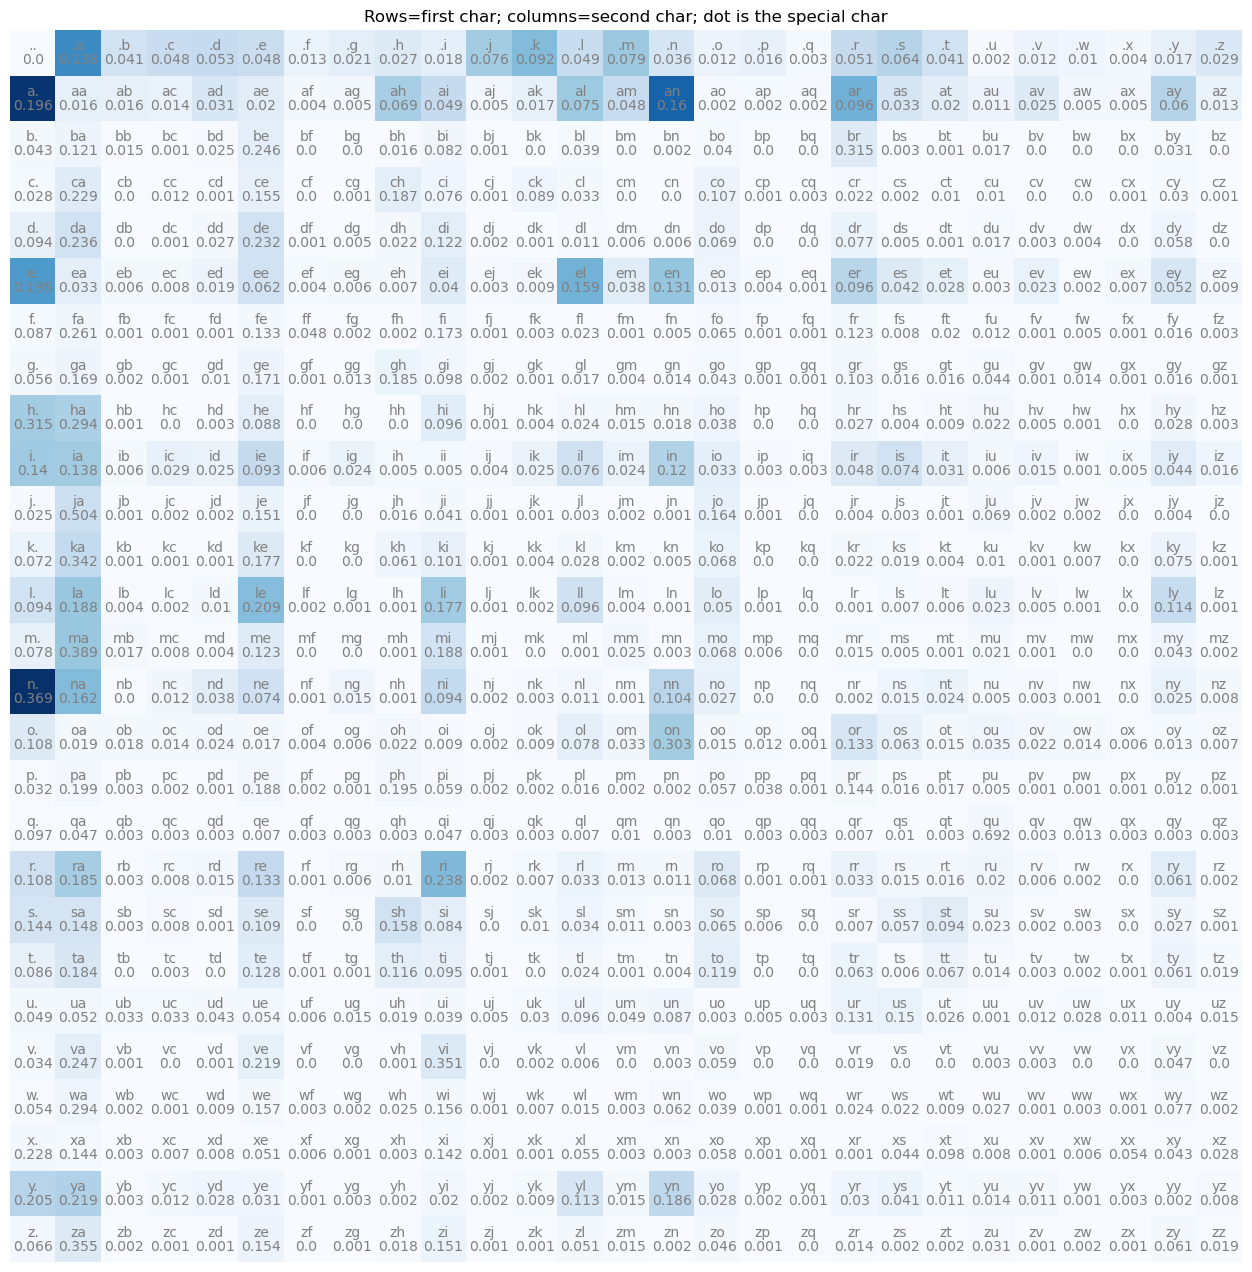

In [223]:
# Vis
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(P[i, j].item(), 3), ha="center", va="top", color='gray')
plt.axis('off')
plt.title('Rows=first char; columns=second char; dot is the special char');

In [224]:
# For each bigram, we can find the probability the model assign to it
# by using matrix P
log_likelihood=0.0
n=0
for w in ['gerritq']:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2]

        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll=-log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-27.2588)
nll=tensor(27.2588)
nll/n=tensor(3.4073)


Now, after havoing added a 1 to all conts, that is, model smoothing, we do not get a minus infinity, but a significnalty larger nll, whicih indcates that the name "gerritq" is very unliely to appear in the data, compared to the average of 2.4.

#### Intermediate Summary 2

We by now have trained a bigram languagde model. We have done the following steps:

1. We trained by counting the bigrams of the training data

2. Smoothed by adding a one to the counts

3. Normalised by rows to get the probability distributions of bigrams which we used as parameters.

4. We can use those parameters and random samling to create new words. 

5. Finally, we can evaluate the quality of the model by the NLL. The aim is to tune parameters to minmise the NLL.



## Language Model: NN approach

The NN approach follows th same logic as above, but instead of computing the probabilities from the counts of the bigrams in the data we will use the NN to compute those. We will use backrpop to minimise the NLL.

The NN follows the same approach. We will input a single character, and it will output the probability distribution of what other character is most likely to follow. We will use the training data to get the true labels of what comes next after a given char, and will use those lables comparing it to the model probabilities to compute the NLL.



### Create training set

First, we will build the training set where we have innputs of chars and outputs. The outputs are the next char of the inputted chars.

In [237]:
xs, ys = [], []
# Build bigrams
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # exploit zip to get bigrams
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# Get tensors instead of list
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [238]:
print(xs)
print(ys)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


This outputs the first word "Emma" by its integer positions for `xs` and the subsequwnet token of each token in this list in `ys`. This isnlge word provides five examples for the NN, as there are five bigrams from this name. For example, when we input 0, the ".", to the NN, we want the NN to assign a high probability of 5, or "e", and so forth. So we want for a given inout in `xs` that the model optimises its weights to assign a high probability to the corresponding `ys` label.

### One-hot encoding

How do we feed these `xs` into the neural network. We cannot simply input the integer value as the neurons will apply the dot product to it and treat it as a continuous variable. Instead we can one-hot enode each integer input, a zero vector of the size of the chars which is one for the position of the char.

We have 5 examples from the first word "emma". We can encode each of those as a one-hot which gives us a 5x27 matrix, where rows are the exmaples and columns the classes of the prediction. Each row is one example to the NN.

In [250]:
# Get one-hot vector for each integer; dim 5x27
xenc = F.one_hot(xs, num_classes=27).float() # cast to float for the NN

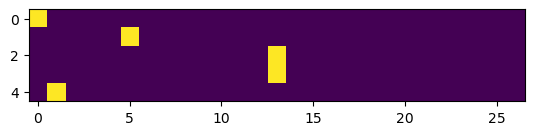

In [251]:
# Visualise the encoding
plt.imshow(xenc)

### Layer construction

Now we construct the first layer and only layer.

Matrix multiplication efficiently performs the dot product on multiple inputs (batching) and mutliple weights, which is called parallelism.  
We take the input layer, a $5x27$ matrix and multiply it with the first layer, for which we want to have 27 neurons. Thus the matrix multiplication is 5x27 x 27x27, which yields a 5x27 matrix. The inner dimensions of the matrix multiplication (both 27s) are multiplied and summed up. The weight's matrix first dimension is its input, wich is of size 27 because of the size of `xs`. Its second dimension is the number of neurons in that layer.

In [285]:
# Weight matrix
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g) 
W

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
          2.4968e+00,  2.4448e+00],
        [-6.7006e-01, -1.2199e+00,  3.0314e-01, -1.0725e+00,  7.2762e-01,
          5.1114e-02,  1.3095e+00, -8.0220e-01, -8.5042e-01, -1.8068e+00,
          1.2523e+00, -1.2256e+00,  1.2165e+00, -9.6478e-01, -2.3211e-01,
         -3.4762e-01,  3.3244e-01, -1.3263e+00,  1.1224e+00,  5.9641e-01,
          4.5846e-01,  5.4011e-02, -1.7400e+00,  1.1560e-01,  8.0319e-01,
          5.4108e-01, -1.1646e+00],
        [ 1.4756e-01, -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01,  1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,
          9.3743e-01, -8.8303e-01,  1.74

In [254]:
# Multiply xenc with the weights
xenc @ W

tensor([[ 0.8739, -0.1690, -0.6945,  0.0374, -0.7621,  1.3261, -1.9601,  1.6184,
         -0.6549,  0.4085,  0.0082, -0.4291, -0.6434, -0.3985, -1.1006, -0.1057,
          0.2489,  0.6010,  0.4404, -0.4790,  0.1471, -1.5090, -1.0906,  0.2482,
         -0.5512, -0.4258, -0.1519],
        [ 0.2747, -0.7893, -0.8326, -0.7720, -1.6732, -0.6719, -0.0728, -0.9485,
          0.4141,  0.1689,  0.6282,  0.0668,  0.9366,  0.3825, -0.4981, -1.0430,
          1.1723,  0.7089,  1.1597, -0.7293, -0.8047, -2.2718,  0.1828, -0.0266,
          0.9199,  1.7927,  1.1435],
        [-1.1489, -0.1041, -0.3581, -0.3175, -1.8082, -2.9064,  0.0334, -1.0517,
          0.6204, -0.9248, -0.2428,  0.4644, -0.5554, -0.0811, -0.5075,  0.8190,
          0.9871,  0.1248, -1.4505, -0.7201, -1.2277, -0.5141, -0.4041, -1.6625,
          0.8325, -2.1023,  0.6763],
        [-1.1489, -0.1041, -0.3581, -0.3175, -1.8082, -2.9064,  0.0334, -1.0517,
          0.6204, -0.9248, -0.2428,  0.4644, -0.5554, -0.0811, -0.5075,  0.8190

__Parallelism and batching__

The crux here is that we have fed 5 examples in parallel, and not just one example at a time. The matrix mutliplication `senc @ X` thus computes all 27 neurons _in parallel_. Feeding in more than one input at a time is called a _batch_.

This 5x27 matrix contains the 27 activation functions for each of the input. Each row is an input, and each corresponding vector contains the 27 activiation functions for this input. 

__Note on neurons__

Note that we have a linear activation and no bias term, we thus have a linear layer only.

In [ ]:
# As an exmaple
(xenc @ W)[3][13]

This is the thirteenth neuron of the third input, and gives the "firing rate" of this neuron.

### Softmax

The layer has 27 outputs but those are the fire rates from each neuron. What we want, however, is a probability distributions over all possible outputs. The aim is to convert all neuron outputs into probabilities which is done using the _softmax_. Softmax is an activation function applied to the last layer of a neural net that transforms the logits into probabilities. The softmax function is:

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

- Logits ($z_i$): These are the raw, unnormlaised outputs of the last layer of a neural net. I.e. the outputs of the neurons of the last layer, before they have been passed to an activation function such as the softmax. 

- Counts ($e^{z_i}$): Applying exponentiation to the logits transforms them into a non-negative space. More specifically, all positive logits are transformed into a value larger than 1 up unitl infinity, whereas all negative logits are transforemd into values between 0 and 1. See the below exponential function. We can interpret this sole transformation as the counts of the next chars.

- Probabilities: The exponentiate values are then summed and each is divided by the sum, which transforms the counts into probabilies between 0-1, and the sum of all values of the layer is 1.

The softmax thus trnsofrms the logits into a probability distribution for the next character in the sequence.

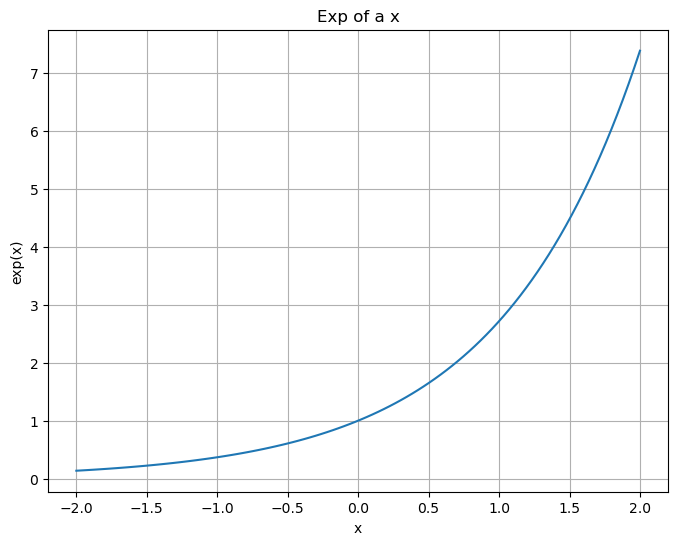

In [269]:
# Gen x and y values
x = np.linspace(-2, 2, 100)
y = np.exp(x)

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Exp of a x')
plt.xlabel('x')
plt.ylabel('exp(x)')
plt.grid(True)
plt.show()

In [286]:
# Forward pass
logits = xenc @ W # These are the raw neurons

# Softmax
counts = logits.exp() # These are the counts
probs = counts / counts.sum(1, keepdims=True) # This is the normalisation of counts

In [287]:
# Same shape but probability distribution
print(probs.shape)
print(probs.sum(1)) 
probs

torch.Size([5, 27])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

What we have achieved is that we have the same shape of the output, but now we have a probability distribution for each input as an output. The NN thus learns and outputs the probability distribution for a the next chars of the inputted char. As expected, each row probabilities sum to 1.

So, for a given char the NN outputs a probability distribution in the similar logic to rows of the the `P` matrix above. Take the below example:


In [273]:
# Probabiloty distribution for the first input
probs[0]

tensor([0.0781, 0.0275, 0.0163, 0.0338, 0.0152, 0.1228, 0.0046, 0.1645, 0.0169,
        0.0490, 0.0329, 0.0212, 0.0171, 0.0219, 0.0108, 0.0293, 0.0418, 0.0595,
        0.0506, 0.0202, 0.0378, 0.0072, 0.0110, 0.0418, 0.0188, 0.0213, 0.0280])

The first input of the word is ".". So given the probability distribution from `P` for "." we would expect that the model learns the chars that are most likely to follow this char.

## Intermediate Summary NN

The way we inputted data into the NN is as follows:

1. Split a word into `x` and `y` values, get the integer values for each char

2. Feed the `x` values into the network as a batch as one-hoe encoded vectors

We get a probability distribution of the subsequent char as an output by passing the logits into a softmax activation function. We evaluate the probability dsitribution with the `y`s from the training data with the NLL loss.

The crucial feature is that the softmax is differnetiable and we can use backprop to opitmise the weights, i.e., find the optimal matrix `W` that minimises the loss.

We have created the NN consisting of one layer, and can now get for each `x` and `y` the value of the loss function, NLL. We do this for the first word only, "Emma".

In [292]:
nlls=torch.zeros(5)
for i in range(5): 
    x = xs[i].item()
    y = ys[i].item()

    print(f'bigram example {i+1}: {itos[x]}{itos[y]} indexes {x},{y}')
    print(f'input to the nn {x}')
    print(f'output probs from the nn {probs[i]}')
    print(f'true label, next actual chars {y}')
    p = probs[i, y]
    print(f'true label assigned prob {p}') # Use index from ys to index prob distribution
    
    logp = torch.log(p)
    nll = -logp
    nlls[i] = nll
    print('nll ', nll.item())

print('avg nll ', nlls.mean().item())

bigram example 1: .e indexes 0,5
input to the nn 0
output probs from the nn tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
true label, next actual chars 5
true label assigned prob 0.012286253273487091
nll  4.3992743492126465
bigram example 2: em indexes 5,13
input to the nn 5
output probs from the nn tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
true label, next actual chars 13
true label assigned prob 0.018050702288746834
nll  4.014570713043213
bigram example 3: mm indexes 13,13
input to the nn 13
output probs from the nn tensor([0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
  

The NLL is computed for a single batch, here consisting of the five examples of the word "emma". We get the NLL for each prediction and finally take the average over all predictions of this batch. We see, for example, that the NN predcits that "e" follows "." with a mere 1 percent. This is because we have not trained the model yet. The weights are just random initialisations, we expect the NLL to drop significanlty after the training. Overall, the loss of the network is 3.7 which is failry high.

## Training the NN on the entire data

The training is dependned on the loss which we have just implemented. The loss is made of differentiable opertaiotns which we will use for the backprop. We will tune the weights to minimise the NLL. The process is as follows:

1. Feedforward: input the chars, get predictions and a value for the loss

2. Clean gradients of weights

3. Apply backprop

4. Use gradient descent to update model paramters

As a note, this is very similar to the training in micrograd (see other notebook in this repository). Below we perform one optimisation step for "Emma".

In [388]:
# Initialise weight matrix
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) 

# Forward pass
logits = xenc @ W # These are the raw neurons

# FP: Softmax
counts = logits.exp() # These are the counts
probs = counts / counts.sum(1, keepdims=True) # This is the normalisation of counts

# Compute the loss
loss= -probs[torch.arange(5), ys].log().mean() # index true lables, get their log, minus, and mean
loss

tensor(3.7693, grad_fn=<NegBackward0>)

This is the NLL after the first feedforward pass of the word "Emma". The loss function takes the logged mean of the probabilities of for the _right_ labels.

Next we perrom the backprop and gradient descent. Note that setting gradients to `None` is more efficient than setting them to 0.

In [322]:
# Backward operations
W.grad=None
loss.backward()

# Update weights with gradient descent
W.data+=-.1*W.grad

This is the backpropagation which first sets all grads to 0, and then computes the gradients for the weights. The gradient descent then applies the gradients to the weights by the learning rate of 0.1.

In [323]:
# Forward pass
logits = xenc @ W # These are the raw neurons

# FP: Softmax
counts = logits.exp() # These are the counts
probs = counts / counts.sum(1, keepdims=True) # This is the normalisation of counts

# Compute the loss
loss= -probs[torch.arange(5), ys].log().mean() # index true lables, get their log, minus, and mean
loss

tensor(3.7492, grad_fn=<NegBackward0>)

We can now repeat the forward pass, compute the new loss and observe that for the same input, the loss has decreased due to the update of the weights.

Now we can put all steps together and perform the optimisation on the entire data. Note that we do not batch, we use all the examples from the training data indeed.

In [390]:
# 1. First: create training daa from the entire sample
xs, ys = [], []
# Build bigrams
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # exploit zip to get bigrams
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# Get tensors instead of list
xs = torch.tensor(xs)
ys = torch.tensor(ys)
n=xs.numel()

In [330]:
# The total number of training examples is
n

228146

In [391]:
# 2. We run the NN on the entire training sample
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) 

# Cast inputs to one-hot encoding
xenc = F.one_hot(xs, num_classes=27).float() # cast to float for the NN

In [392]:
for e in range(100):

    # Forward pass
    logits = xenc @ W # These are the raw neurons

    # FP: Softmax
    counts = logits.exp() # These are the counts
    probs = counts / counts.sum(1, keepdims=True) # This is the normalisation of counts

    # Compute the loss
    loss= -probs[torch.arange(n), ys].log().mean() + 0.01*(W**2).mean() # index true lables, get their log, minus, and mean
    loss

    # Backward operations
    W.grad=None
    loss.backward()

    # Update weights with gradient descent
    W.data+=-50*W.grad

    print(loss)

tensor(3.7686, grad_fn=<AddBackward0>)
tensor(3.3788, grad_fn=<AddBackward0>)
tensor(3.1611, grad_fn=<AddBackward0>)
tensor(3.0272, grad_fn=<AddBackward0>)
tensor(2.9345, grad_fn=<AddBackward0>)
tensor(2.8672, grad_fn=<AddBackward0>)
tensor(2.8167, grad_fn=<AddBackward0>)
tensor(2.7771, grad_fn=<AddBackward0>)
tensor(2.7453, grad_fn=<AddBackward0>)
tensor(2.7188, grad_fn=<AddBackward0>)
tensor(2.6965, grad_fn=<AddBackward0>)
tensor(2.6774, grad_fn=<AddBackward0>)
tensor(2.6608, grad_fn=<AddBackward0>)
tensor(2.6464, grad_fn=<AddBackward0>)
tensor(2.6337, grad_fn=<AddBackward0>)
tensor(2.6225, grad_fn=<AddBackward0>)
tensor(2.6125, grad_fn=<AddBackward0>)
tensor(2.6037, grad_fn=<AddBackward0>)
tensor(2.5958, grad_fn=<AddBackward0>)
tensor(2.5887, grad_fn=<AddBackward0>)
tensor(2.5823, grad_fn=<AddBackward0>)
tensor(2.5764, grad_fn=<AddBackward0>)
tensor(2.5711, grad_fn=<AddBackward0>)
tensor(2.5663, grad_fn=<AddBackward0>)
tensor(2.5618, grad_fn=<AddBackward0>)
tensor(2.5577, grad_fn=<A

The final NLL we achieve with the NN approach is about the same as the explicit approach by counting bigrams and computing the probabilities. This is because we still exploit the same information of bigrams and do not add any new information. The gradient based approach thus achieves the same performance as simple counting. 

The NN approach offers a significant boost in felxibility. We can expand the architecture, easily feed more the just one char as input etc., and will keep the last layer here the softmax transforms logits into probabilities. This is the distinct advantage of it compared to counting bigrams.

## Summary

The NN approach yields the same results as counting. The weight matrix `W` serves as the count matrix. With a one-hot vector, similar to the count matrix, the row in the weight matrix is selected with which the logits are obtained from which the probability distribution is computed with softmax. Hence, the weight matrix has  the identical functionality as the count matrix `N` in the counting approach. `W` is literaly the same as the `N` matrix.

The distinct difference is how we get to the parameters of each. For `N` we simply count the occurences of bigrams. For `W` we use gradient-based optimisation.

This notebook introduces the bigram languade model, how we train it, how we sample from it, and how we evaluate it (NLL). We showed two approaches to train the model that yield the same result.
First approach, we simply count the occurcenes of bigrams and normalise. Second approach, we use the NLL to optimise the weight matrix of a NN. Both give the same result, while the latter is more flexible, we will expand this in the next notebook.


__Comparison NN and counting__

The final NLL we achieve with the NN approach is about the same as the explicit approach by counting bigrams and computing the probabilities. This is because we still exploit the same information of bigrams and do not add any new information. The gradient based approach thus achieves the same performance as simple counting. 

The NN approach offers a significant boost in flexibility. We can expand the architecture, easily feed more the just one char as input etc., and will keep the last layer the softmax to transforms logits into probabilities. Fundamentally, we will only change the forward pass, everything else will be simialr if not identical to this NN implementation.

This is the distinct advantage of it compared to counting bigrams. The bigram LM works well as we are only looking at two chars, which facilitates simple counts, but increasing the dependencies renders this method intractable (count table gets to large). This is where the gradient-based approach is used, as it is more scalable.

__Optimisation__


- One-hot encoding: because of the matrix multiplication, a one-hot encoded vector simply plugs out the row of the weights matrix where the vector is one. Thus a one-hot vector can be seen as simply accessing the corresponding row of the weights matrix. For example, if the 2nd value is one in a one-hot encoded vector, matrix multiplication will select the full second row of the weight matrix. Hence, an optimisation is to simply index the weight matrix rather performing matrix multiplication.

Hence, the weight matrix `W` serves as the count matrix. With a one-hot vector, similar to the count matrix, the row in the weight matrix is selected with which the logits are obtained from which the probability distribution is computed with softmax. Tthe weight matrix has the identical functionality as the count matrix `N` in the counting approach. `W` is literaly the same as the `N` matrix.
Softmax then takes the `exp` and computes probabilietes form the row, which follows the same idea as transforming the count matrix `N` to the matrix of probabilites `P`. More precisely, both matrices are the same at the end of optimising the NN.

The __difference__ is how we come about the `W` and `N`. For the count apporach we populate the matrix by simply counting the occurences of bigrams. For the NN approach, we randomly initilise the matrix and then let gradient-based optimisation find the numbers.

- Smoothing: The more we smooth in `P` the more uniform the probability distributions get. Adding a million to evry count makes the differences of actual counts marginal, which makes the probability of each bigram almost equal. The equivakent of smoothig for NN is to randomly initiate weights. Say we initialise all weights with 0, the softmax would output a perfeclty uniform probability distribution (logits = 0, exp of 0 is 1, diving all gives equal probs.). Hence, initiliasing the weights closer to zero is tantamunt to more model smoothing.

- Regularisation: We cann add a regularisation to the loss to prevent overfitting.The incentive here is that the loss now has two compenents. The first is the NLL which seeks to find the optimal probabilites. The second is `(W**2).mean()`, the regulariation component, which seeks to keep all weights close to 0, as the goal is to minimise the entire loss.

- Conection regularisation-smoothing: the regularisation paramter is controlling the amount of smoothing. A higher parameter means more regularisation, meaning the force to push weights to zero is higher, meaning more model smoothing, and vice versa. Or, more regularisation corresponds to more more restriction in the ability to obtain non-zero values, which is similar to more unfirm predictions.

In [ ]:
# Optimisation
torch.equal(W[xs],xenc @ W)